<a href="https://colab.research.google.com/github/SarojiniMaddaraki/AirQualityDetection/blob/main/WEEK2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.Loading the cleaned data from week1.**

In [21]:
from google.colab import files
uploaded = files.upload()


Saving clean_city_day (1).csv to clean_city_day (1) (1).csv


2.Retrieve firsr 5 samples.

In [22]:
import pandas as pd

df = pd.read_csv("clean_city_day (1).csv")   # make sure name matches exactly
print(df.shape)
df.head()


(28000, 33)


,city,date,pm2_5,pm10,no,no2,nox,nh3,co,so2,...,pm10_ma3,pm10_ma7,no2_ma3,no2_ma7,so2_ma3,so2_ma7,o3_ma3,o3_ma7,co_ma3,co_ma7
0,Ahmedabad,2015-01-01,76.38,109.84,0.92,18.22,17.15,17.27,0.92,27.64,...,119.44,115.941429,18.220000,69.200714,27.640000,59.012857,133.360000,43.063571,0.920000,22.652857
1,Ahmedabad,2015-01-02,76.38,109.84,0.97,15.69,16.46,17.27,0.97,24.55,...,119.44,115.941429,16.955000,69.200714,26.095000,59.012857,83.710000,43.063571,0.945000,22.652857
2,Ahmedabad,2015-01-03,76.38,109.84,17.40,19.30,29.70,17.27,17.40,29.07,...,119.44,115.941429,17.736667,17.736667,27.086667,27.086667,66.040000,66.040000,6.430000,6.430000
3,Ahmedabad,2015-01-04,76.38,109.84,1.70,18.48,17.97,17.27,1.70,18.59,...,119.44,115.941429,17.823333,17.922500,24.070000,24.962500,33.613333,58.550000,6.690000,5.247500
4,Ahmedabad,2015-01-05,76.38,109.84,22.10,21.42,37.76,17.27,22.10,39.33,...,119.44,115.941429,19.733333,18.622000,28.996667,27.836000,35.363333,54.702000,13.733333,8.618000


3.Sorting for better.

In [23]:
# Check columns & a few nulls
print(df.columns.tolist())
df.isna().sum().sort_values(ascending=False).head(10)


['city', 'date', 'pm2_5', 'pm10', 'no', 'no2', 'nox', 'nh3', 'co', 'so2', 'o3', 'benzene', 'toluene', 'xylene', 'aqi', 'aqi_bucket', 'year', 'month', 'day', 'day_of_week', 'is_weekend', 'pm2_5_ma3', 'pm2_5_ma7', 'pm10_ma3', 'pm10_ma7', 'no2_ma3', 'no2_ma7', 'so2_ma3', 'so2_ma7', 'o3_ma3', 'o3_ma7', 'co_ma3', 'co_ma7']


,0
aqi_bucket,3150
city,0
date,0
pm10,0
pm2_5,0
no2,0
nox,0
nh3,0
no,0
co,0


PART A — Regression:1. Predict numeric aqi.

In [24]:
drop_cols = ['city','date','aqi','aqi_bucket']  # targets / non-numeric IDs
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
y = df['aqi'].astype(float)

# If any rows have missing y, drop them
keep = y.notna()
X, y = X.loc[keep].copy(), y.loc[keep].copy()

X.shape, y.shape


((28000, 29), (28000,))

2. Time-aware train/test split (avoid leakage)

In [25]:
df_sorted = df.loc[keep, ['date']].copy()
df_sorted['date'] = pd.to_datetime(df_sorted['date'], errors='coerce')

order = df_sorted['date'].sort_values().index
cut = int(len(order) * 0.8)
train_idx, test_idx = order[:cut], order[cut:]

X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

X_train.shape, X_test.shape


((22400, 29), (5600, 29))

3. Baseline model (Linear Regression)

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

lin = LinearRegression()
lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)

r2_lin  = r2_score(y_test, pred_lin)
mae_lin = mean_absolute_error(y_test, pred_lin)
rmse_lin= np.sqrt(((y_test - pred_lin)**2).mean())

print("Linear Regression →  R²:", round(r2_lin,3), " MAE:", round(mae_lin,2), " RMSE:", round(rmse_lin,2))


Linear Regression →  R²: 0.859  MAE: 21.18  RMSE: 34.87


4. Stronger model (RandomForest Regressor)

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

r2_rf  = r2_score(y_test, pred_rf)
mae_rf = mean_absolute_error(y_test, pred_rf)
rmse_rf= np.sqrt(((y_test - pred_rf)**2).mean())

print("RandomForest → R²:", round(r2_rf,3), " MAE:", round(mae_rf,2), " RMSE:", round(rmse_rf,2))


RandomForest → R²: 0.919  MAE: 14.84  RMSE: 26.41


5. Compare & choose (and save predictions)

In [28]:
import pandas as pd

print({
    "Linear_R2": r2_lin, "Linear_MAE": mae_lin, "Linear_RMSE": rmse_lin,
    "RF_R2": r2_rf, "RF_MAE": mae_rf, "RF_RMSE": rmse_rf
})

# Save predictions for mentor review
out = pd.DataFrame({
    "date": df.loc[test_idx, 'date'].values,
    "city": df.loc[test_idx, 'city'].values,
    "aqi_true": y_test.values,
    "aqi_pred_linear": pred_lin,
    "aqi_pred_rf": pred_rf
})
out.to_csv("week2_aqi_predictions.csv", index=False)
print("Saved: week2_aqi_predictions.csv")


{'Linear_R2': 0.8594189943369206, 'Linear_MAE': 21.177192574374995, 'Linear_RMSE': np.float64(34.86768526001394), 'RF_R2': 0.9193716194330126, 'RF_MAE': 14.842238257869775, 'RF_RMSE': np.float64(26.40606954334688)}
Saved: week2_aqi_predictions.csv


6. Show top features for RF

In [29]:
import numpy as np

feat_names = X.columns
imp = rf.feature_importances_
top = np.argsort(imp)[::-1][:10]
[(feat_names[i], round(float(imp[i]),4)) for i in top]


[('pm2_5_ma3', 0.2524),
 ('pm2_5', 0.2521),
 ('co', 0.1795),
 ('co_ma3', 0.164),
 ('no', 0.0307),
 ('co_ma7', 0.028),
 ('pm10', 0.0183),
 ('pm10_ma3', 0.0109),
 ('o3', 0.0061),
 ('nox', 0.0053)]

7.Visualization of predictions.





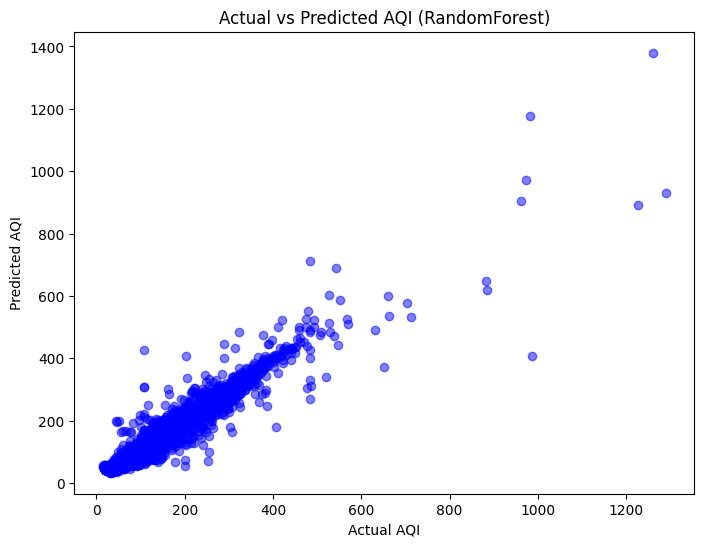

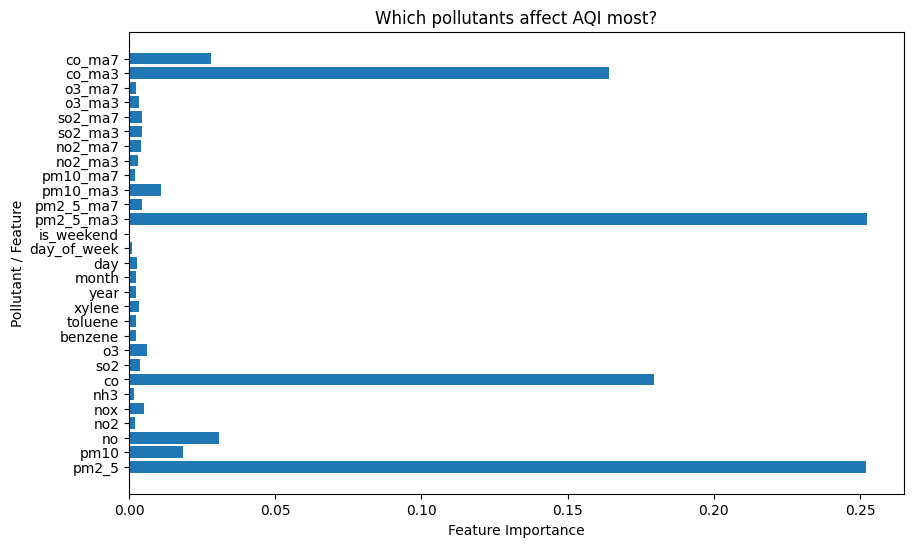

In [30]:
import matplotlib.pyplot as plt

# Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_rf, alpha=0.5, color='blue')
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Actual vs Predicted AQI (RandomForest)")
plt.show()

# Feature Importance
importances = rf.feature_importances_
feat_names = X.columns
plt.figure(figsize=(10,6))
plt.barh(feat_names, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Pollutant / Feature")
plt.title("Which pollutants affect AQI most?")
plt.show()


# **Optional : Classification using aqi_bucket.

In [17]:
dfc = df.dropna(subset=['aqi_bucket']).copy()
Xc = dfc.drop(columns=['city','date','aqi','aqi_bucket'], errors='ignore')
yc = dfc['aqi_bucket'].astype(str).str.strip().str.title()

dfc_dates = pd.to_datetime(dfc['date'], errors='coerce')
order_c = dfc_dates.sort_values().index
cut_c = int(len(order_c)*0.8)
train_c, test_c = order_c[:cut_c], order_c[cut_c:]

Xc_train, Xc_test = Xc.loc[train_c], Xc.loc[test_c]
yc_train, yc_test = yc.loc[train_c], yc.loc[test_c]

Xc_train.shape, Xc_test.shape, yc_train.value_counts().to_dict()


((19880, 29),
 (4970, 29),
 {'Moderate': 7145,
  'Satisfactory': 6132,
  'Poor': 2400,
  'Very Poor': 2113,
  'Severe': 1280,
  'Good': 810})

1.Train & evaluate classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

clf = RandomForestClassifier(
    n_estimators=400,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
clf.fit(Xc_train, yc_train)
yc_pred = clf.predict(Xc_test)

print("Accuracy:", round(accuracy_score(yc_test, yc_pred),3))
print("Macro F1:", round(f1_score(yc_test, yc_pred, average='macro'),3))
print(classification_report(yc_test, yc_pred))


Accuracy: 0.836
Macro F1: 0.819
              precision    recall  f1-score   support

        Good       0.86      0.72      0.78       531
    Moderate       0.86      0.82      0.84      1684
        Poor       0.75      0.76      0.75       381
Satisfactory       0.83      0.90      0.86      2092
      Severe       0.81      0.86      0.83        58
   Very Poor       0.87      0.82      0.85       224

    accuracy                           0.84      4970
   macro avg       0.83      0.81      0.82      4970
weighted avg       0.84      0.84      0.84      4970

